In [1]:
# Installing ML Flow and Google Cloud Storage
!pip3 install mlflow
!pip3 install fsspec
!pip3 install gcsfs
!pip3 install -q vectice
!pip3 show vectice
!pip install vectice[github]==0.23.1 --extra-index-url=https://test.pypi.org/simple/

     |████████████████████████████████| 15.6 MB 330 kB/s 
     |████████████████████████████████| 180 kB 41.1 MB/s 
     |████████████████████████████████| 596 kB 23.8 MB/s 
     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 146 kB 42.8 MB/s 
     |████████████████████████████████| 58 kB 4.1 MB/s 
     |████████████████████████████████| 210 kB 37.9 MB/s 
     |████████████████████████████████| 53 kB 815 kB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 75 kB 3.3 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.16.3-py3-none-any.whl size=106866 sha256=2ab3f4184c3a878d7a7a885cf0e85f8ccb55904d8dceb0eb1fe7b49c3e7de06a
  Stored in directory: /root/.cache/pip/wheels/ff/6f/97/f72d28ceea4408d11061e0a8b1400fea327e5135601c347147
Successfully built databricks-cli
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [2]:
# Retrieve from GCS
from google.colab import files
uploaded = files.upload()

Saving readerKey.json to readerKey.json


In [3]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from vectice import Vectice

In [ ]:
# read dataset from gcs
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'readerKey.json'
df = pd.read_csv('gs://vectice-sales-demo/fraud_detection_bank_dataset.csv')
df.head()

In [23]:
# API Token : AgnL7oBdZ.ojpal5Go6VkLRP3QDXOb0AgnL7oBdZK9YEMqy17z4rJ2x8NmWv
#Import the Vectice library
from vectice import Vectice
from vectice.models import JobType
# Specify the API endpoint for Vectice. This shouldn’t change.
os.environ['VECTICE_API_ENDPOINT']= "beta.vectice.com"      #"test-public.vectice.com"
os.environ['VECTICE_API_TOKEN'] = "MRoyNKEjX.wpk4L8xJWOa59eY0DAGwKMRoyNKEjXy13bBlgdVNQz67rvPqm2"

# Project_Token
vectice = Vectice(project_token="aJrVnBdyc27p6mQoq9kx")

# check if tokens are valid
vectice.list_jobs()

PagedResponse(total=0, list=[], current_page=Page(index=1, size=20))

In [ ]:
# The Vectice Python library automatically detects if there have been changes to the dataset you are using.
# If it detects changes, it will generate a new version of your dataset automatically. 
# For this tutorial, we changed the data since Albert left the company.
# So, the Vectice Python library will create a new dataset version the first time you execute this code.

input_ds_version = vectice.create_dataset_version().with_parent_name("cleaned_FraudCustomer_data")


# With this line we declare a reference to code existing in GitHub as the code at the origin of the outputs
input_code = Vectice.create_code_version_with_github_uri("https://github.com/shaiffali/Vectice",
                        "FraudDetection.ipynb") 



# Each execution for a given job is called a run. When creating a run you need to specify:
# 1) a job name (mandatory)
# 2) a job type (optional)
# Job names and job types are useful to group and search runs in the Vectice UI.
# For this run, we will use the job name "80/20 Split" and the job type "PREPARATION"
vectice.create_run("80/20 Split", JobType.PREPARATION)
vectice.start_run(inputs=[input_ds_version,input_code])

# We will use an 80/20 split to prepare the data
test_size = 0.2

# We will set the random seed so we always generate the same split.
random_state = 42

train, test = train_test_split(df, test_size = test_size, random_state = random_state)

# We commented out the code to persist the training and testing test in GCS, 
# because we already generated the data for you.
# The key provided for this tutorial give you read access only to GCS.
# We left the code below for convenience, in case you want to use your own credentials and GCS bucket.
# train.to_csv (r'gs://vectice_tutorial/training_data.csv', index = False, header = True)
# test.to_csv (r'gs://vectice_tutorial/testing_data.csv', index = False, header = True)

# Generate X_train, X_test, y_train, y_test, which we will need for modeling
X = df.drop("price", axis=1).values
y = df["price"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


# Let's create new versions of the training and testing dataset if the data has changed.
# We will use the existing dataset created by Albert, so that we can append new 
# dataset versions to it.
train_ds_version = vectice.create_dataset_version().with_parent_name("train_cleaned_kc_house_data")
test_ds_version = vectice.create_dataset_version().with_parent_name("test_cleaned_kc_house_data")

# End the run, and attach the output datasets to it.
vectice.end_run(outputs=[train_ds_version,test_ds_version])

# We can preview one of our generated outputs to make sure that everything was executed properly.
X_train

In [ ]:
# Exploratory Data Analysis
# df.info()
df.describe()

In [6]:
# If column contain only one unique value than that column is not important let's check

for col in df.columns:
    if len(df[col].unique()) == 0:
        print(col, " ")

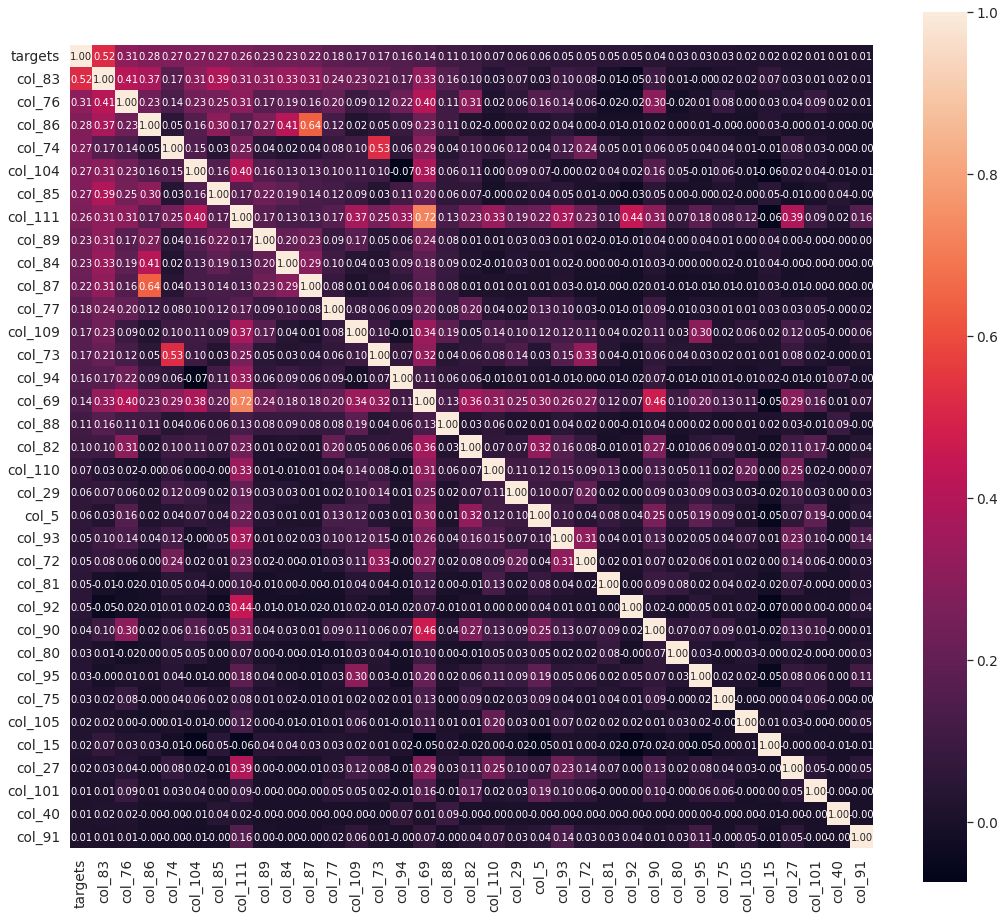

In [7]:
# Here is correlation matrix of top 35 value that mostly correlated with targets columns
plt.figure(figsize = (18, 16))
corrmat = df.corr()
k = 35 #number of variables for heatmap
cols = corrmat.nlargest(k, 'targets')['targets'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [8]:
# Defining X  & Y Variables -
X = df.drop(["targets"], axis = 1).values
y = df["targets"].values

In [9]:
# K-Nearest-Neighbor (KNN)
# Applying KNN Algorithm and Analyzing results through Validation Curve
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
param_range = np.array([70, 65, 60, 55, 50, 40, 35, 30, 25, 20, 15, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1])

train_scores, test_scores = validation_curve(KNeighborsClassifier(), X, y, param_name = "n_neighbors", param_range = param_range)
print(train_scores)

[[0.98815195 0.98009039 0.98002931 0.98229008 0.98473282]
 [0.98851838 0.98106755 0.98039575 0.98296183 0.98546565]
 [0.98888482 0.98149505 0.98088433 0.98320611 0.98589313]
 [0.98931232 0.98198363 0.98173934 0.98351145 0.98619847]
 [0.98949554 0.98265543 0.98198363 0.98375573 0.98680916]
 [0.99108342 0.98393795 0.98296079 0.98503817 0.98815267]
 [0.99218273 0.98552583 0.98460975 0.98601527 0.98894656]
 [0.99267131 0.98595334 0.9851594  0.98656489 0.98949618]
 [0.99346525 0.98741908 0.98668621 0.98766412 0.99083969]
 [0.99377061 0.98766337 0.98748015 0.98821374 0.99151145]
 [0.99529742 0.98986198 0.9898009  0.9900458  0.99322137]
 [0.99657994 0.98998412 0.99016734 0.99071756 0.9941374 ]
 [0.99731281 0.99132771 0.99187737 0.99212214 0.99487023]
 [0.99706852 0.99035056 0.99071699 0.99132824 0.99444275]
 [0.9975571  0.99279345 0.99236595 0.99285496 0.9959084 ]
 [0.99737389 0.99212166 0.99181629 0.99206107 0.99554198]
 [0.99798461 0.99450348 0.99407597 0.99407634 0.99694656]
 [0.99774032 0

In [10]:
print(np.mean(train_scores, axis = 1))

[0.98305891 0.98368183 0.98407269 0.98454904 0.9849399  0.9862346
 0.98745603 0.98796902 0.98921487 0.98972786 0.9916455  0.99231727
 0.99350205 0.99278141 0.99429597 0.99378298 0.99551739 0.99472347
 0.99698309 0.99622581 1.        ]


In [11]:
print(test_scores)

[[0.74328285 0.98998534 0.98339033 0.97727828 0.85585145]
 [0.74181729 0.9902296  0.98485589 0.97776692 0.85585145]
 [0.74132877 0.9902296  0.98510015 0.97801124 0.85536281]
 [0.73864191 0.9902296  0.98583293 0.97801124 0.85536281]
 [0.73961895 0.99047386 0.98632145 0.9787442  0.85414122]
 [0.73717636 0.99193942 0.98778701 0.97923284 0.85414122]
 [0.73400098 0.99242794 0.98851979 0.98094307 0.85438554]
 [0.73009282 0.99242794 0.9890083  0.98167603 0.85365258]
 [0.72300928 0.99340498 0.98998534 0.98265331 0.85511849]
 [0.7198339  0.99364924 0.99096238 0.98265331 0.85438554]
 [0.70786517 0.99462628 0.99291646 0.98558515 0.85536281]
 [0.70639961 0.99462628 0.99340498 0.9863181  0.85462986]
 [0.69418661 0.99438202 0.99364924 0.9887613  0.85682873]
 [0.70102589 0.99462628 0.99364924 0.98705106 0.85462986]
 [0.68661456 0.9951148  0.99487054 0.9887613  0.85609577]
 [0.69345383 0.99487054 0.99364924 0.98778402 0.85487418]
 [0.68099658 0.99658036 0.9951148  0.99096018 0.85756169]
 [0.68954568 0

In [12]:
print(np.mean(test_scores, axis = 1))

[0.90995765 0.91010423 0.91000652 0.9096157  0.90985994 0.91005537
 0.91005546 0.90937154 0.90883428 0.90829688 0.90727117 0.90707577
 0.90556158 0.90619647 0.9042914  0.90492636 0.90424272 0.90492647
 0.90385209 0.90492655 0.90346148]


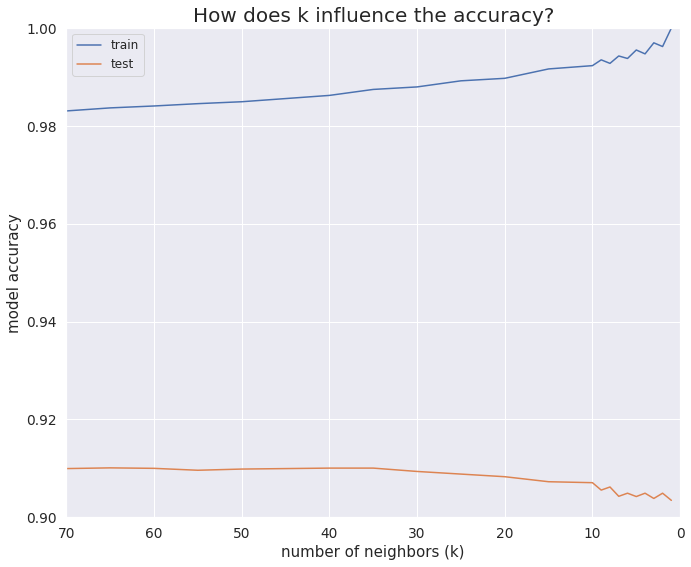

In [13]:
# Visualizing Validation Curve (Bias-Variance Dilemma) dependant from number of neighbors (k argument)
# %matplotlib inline

plt.figure(figsize = (11, 9))

plt.plot(param_range, np.mean(train_scores, axis = 1))
plt.plot(param_range, np.mean(test_scores, axis = 1))

# Reversing the X-axis (now going from 40 to 1 backwards)
plt.xlim(np.max(param_range), 0)
plt.ylim(0.9, 1)

plt.title("How does k influence the accuracy?", fontsize = 20)
plt.xlabel("number of neighbors (k)", fontsize = 15)
plt.ylabel("model accuracy", fontsize = 15)

# Adding a legend
plt.legend(["train", "test"], loc = "upper left", fontsize = 12)

plt.show()

In [14]:
# Decision Tree
X = df.drop(["targets"], axis = 1).values
y = df["targets"].values

In [15]:
# Implementing Decision Tree
from sklearn.tree import DecisionTreeClassifier
param_range = np.arange(1, 100)

train_scores, test_scores = validation_curve(DecisionTreeClassifier(), X, y, param_name = "max_depth", param_range = param_range)
print(train_scores)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1.

In [16]:
print(np.mean(train_scores, axis = 1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]


In [17]:
print(test_scores)

[[0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1.         1.         1.         0.86733447]
 [0.63287738 1

In [18]:
print(np.mean(test_scores, axis = 1))

[0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237
 0.90004237 0.90004237 0.90004237 0.90004237 0.90004237 0.9000

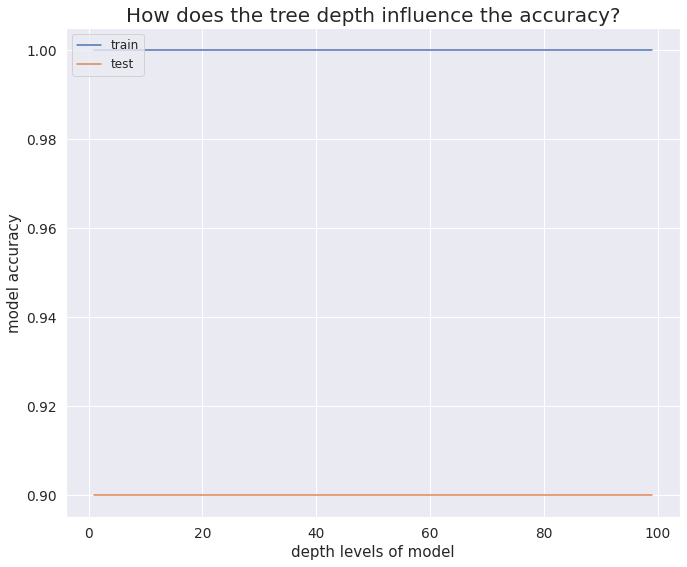

In [19]:
# Visualizing Validation Curve (Bias-Variance Dilemma) dependant from depth level of Decision Tree (max_depth argument)
plt.figure(figsize = (11, 9))

plt.plot(param_range, np.mean(train_scores, axis = 1))
plt.plot(param_range, np.mean(test_scores, axis = 1))

plt.title("How does the tree depth influence the accuracy?", fontsize = 20)
plt.xlabel("depth levels of model", fontsize = 15)
plt.ylabel("model accuracy", fontsize = 15)

# Adding a legend
plt.legend(["train", "test"], loc = "upper left", fontsize = 12)

plt.show()

In [20]:
# Logistic Regression

X = df.drop(["targets"], axis = 1).values
y = df["targets"].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25)

# Scaling data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Applying Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = "liblinear")
model.fit(X_train, y_train)

print(model.score(X_test, y_test))

0.9964823138557749


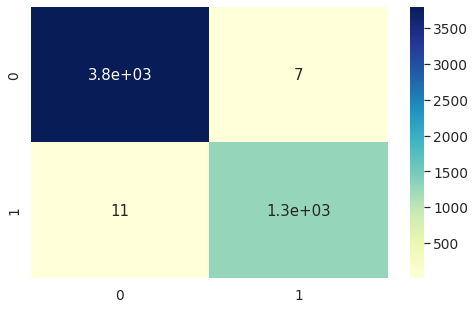

In [22]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (8,5))
sns.heatmap(df_cm, annot=True, cmap='YlGnBu')